<a href="https://colab.research.google.com/github/sachinrkp/JupyterNotebooks/blob/main/ML_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CA684 Machine Learning Assignment Spring 2023

Dublin City University has teamed up with **Etsy** to create the 2023 CA684 Machine Learning assignment.

## Etsy.com

Etsy is the global marketplace for unique and creative goods. It’s home to a universe of special, extraordinary items, from unique handcrafted pieces to vintage treasures. Etsy operates two-sided online marketplaces that collectively connect nearly 100 million passionate and creative buyers and 7.7 million sellers around the world. 

Buyers come to the Etsy marketplace for meaningful, one-of-a-kind items handcrafted and curated with passion and expertise by our creative entrepreneurs. We are focused on attracting potential buyers to Etsy for everyday items that have meaning and those “special” purchase occasions that happen throughout the year. These include items that reflect an individual’s unique style; gifting that demonstrates thought and care; and celebrations that express creativity and fun.

On Etsy, someone searches for …
- Wall art every two seconds
- Wedding-related items every two seconds
- Gift-related items every second
- Antique or vintage items every half a second

## Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers. You are provided a subset of those products as the training data. 

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- top category id
- bottom category id
- color id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category and color). Your approaches and models will be benchmarked against a hidden test dataset.

Bonus points will be given for submissions that:

- the trained model predicts the three attributes at the same time
- visualize some learned representations or embeddings and show that similar items cluster together
- compares the performance of pre-trained embeddings taken from hubs or papers with a fine-tuned model


## Getting Started

Here is some sample code to get you started on the challenge!

Happy Hacking!

In [1]:
# libraries
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

In [2]:
# set random seed
np.random.seed(seed=42)

## Dataset

The train and test datasets are shared in two different formats, parquet and TFRecords, for you to choose which one is more appropriate for your approaches.

In order to download the dataset, please sign the attached NDA and email it to dazcona@etsy.com with copy to legal@etsy.com from your DCU email address using the following subject: *Machine Learning University Challenge Spring 2023 <your DCU username>*

**Note** that images are only in the TFRecords!

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!pwd

/content


In [21]:
#!unzip drive/My\ Drive/data.zip

Archive:  drive/My Drive/data.zip
   creating: data/
   creating: data/tfrecords/
   creating: data/tfrecords/test/
  inflating: data/tfrecords/test/part-00167-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00214-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00029-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00045-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00059-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00195-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00030-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00132-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00201-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00227-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00027-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00209-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00020-of-00278.tfrecord  
  inflating: data/tfrecords/test/part-00203-of-00278

In [63]:
PATH = f"data"

In [65]:
!ls {PATH}

parquet  tfrecords


In [66]:
parquet_filenames_train = !ls {PATH}/parquet/train

In [67]:
parquet_filenames_train[:3]

['part-00000-of-00278.parquet  part-00139-of-00278.parquet',
 'part-00001-of-00278.parquet  part-00140-of-00278.parquet',
 'part-00002-of-00278.parquet  part-00141-of-00278.parquet']

In [68]:
parquet_filenames_test = !ls {PATH}/parquet/test

In [69]:
parquet_filenames_test[:3]

['part-00000-of-00278.parquet  part-00139-of-00278.parquet',
 'part-00001-of-00278.parquet  part-00140-of-00278.parquet',
 'part-00002-of-00278.parquet  part-00141-of-00278.parquet']

In [70]:
tfrecord_filenames_train = !ls {PATH}/tfrecords/train

In [71]:
tfrecord_filenames_train[:3]

['part-00000-of-00278.tfrecord  part-00139-of-00278.tfrecord',
 'part-00001-of-00278.tfrecord  part-00140-of-00278.tfrecord',
 'part-00002-of-00278.tfrecord  part-00141-of-00278.tfrecord']

In [72]:
tfrecord_filenames_test = !ls {PATH}/tfrecords/test

In [73]:
tfrecord_filenames_test[:3]

['part-00000-of-00278.tfrecord  part-00139-of-00278.tfrecord',
 'part-00001-of-00278.tfrecord  part-00140-of-00278.tfrecord',
 'part-00002-of-00278.tfrecord  part-00141-of-00278.tfrecord']

## Exploratory Data Analysis

It is important to familiarize yourself with the dataset by using measures of centrality (e.g. mean) and statistical dispersion (e.g. variance) and data visualization methods. The following is just some Pandas preprocessing and Matplotlib visualizations to get you started. Feel free to explore the data much further and come up with ideas that might help you in the task!

### Training Dataset

This dataset can be used to train models and learn patterns from.

#### Parquet

In [84]:
#print(PATH)
len(parquet_filenames_train)

139

In [88]:
def get_parquet_data(folder, N):
    """ Read parquet data from mutiple files """

    filenames = [ 
        f"{PATH}/parquet/{folder}/part-{i:05d}-of-{N:05d}.parquet" 
        for i in range(N)
    ]

    dataframes = [ 
        pd.read_parquet(filename) 
        for filename in filenames
    ]
    
    return pd.concat(dataframes)

In [89]:
df_train = get_parquet_data("train", 278)

In [90]:
f"Number of rows in train: {len(df_train):,}"

'Number of rows in train: 245,485'

In [91]:
f"Number of unique products in train: {len(df_train['product_id'].unique()):,}"

'Number of unique products in train: 245,485'

In [92]:
f"Number of columns in train: {len(df_train.columns):,}"

'Number of columns in train: 21'

In [93]:
list(df_train.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'color_id',
 'color_text']

In [94]:
df_train.iloc[0]

product_id                                                      543497833
title                   Full-face custom motorcycle helmet ,Motorcycle...
description             Helmetartthai from Thailand ( Since 2016) \n\n...
tags                    predator helmet,motorcycle helmet,helmet,handm...
type                                                             physical
room                                                                 None
craft_type                                                           None
recipient                                                            None
material                                                             None
occasion                                                             None
holiday                                                              None
art_subject                                                          None
style                                                                None
shape                                 

In [95]:
df_train.head(2)

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,art_subject,style,shape,pattern,bottom_category_id,bottom_category_text,top_category_id,top_category_text,color_id,color_text
0,543497833,"Full-face custom motorcycle helmet ,Motorcycle...",Helmetartthai from Thailand ( Since 2016) \n\n...,"predator helmet,motorcycle helmet,helmet,handm...",physical,None,None,None,None,None,...,None,None,None,None,2804,accessories.hats_and_caps.helmets.sports_helme...,0,accessories,12,purple
1,718680498,"Full-face predator motorcycle helmet ,Custom ...",Helmetartthai from Thailand ( Since 2016) \n\n...,"Predator helmet,Custom helmet,Handmade helme,P...",physical,None,None,None,None,None,...,None,None,None,None,2804,accessories.hats_and_caps.helmets.sports_helme...,0,accessories,1,black


In [96]:
df_train['type'].unique()

array(['physical', None, 'download'], dtype=object)

In [97]:
df_train['type'].value_counts(dropna=False)

physical    236137
download      8074
None          1274
Name: type, dtype: int64

In [98]:
COLORS = df_train['color_id'].unique()
NUM_COLORS = len(COLORS)
f"Number of colors in train: {NUM_COLORS:,}"

'Number of colors in train: 20'

In [99]:
f"Number of top categories in train: {len(df_train['top_category_text'].unique()):,}"

'Number of top categories in train: 15'

In [100]:
pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

home_and_living                53200
craft_supplies_and_tools       42348
clothing                       32028
toys_and_games                 14427
accessories                    12610
bath_and_beauty                12426
paper_and_party_supplies       10811
shoes                          10355
weddings                       10333
jewelry                         9457
art_and_collectibles            8741
electronics_and_accessories     8177
books_movies_and_music          7378
bags_and_purses                 6645
pet_supplies                    6549
Name: top_category_text, dtype: int64

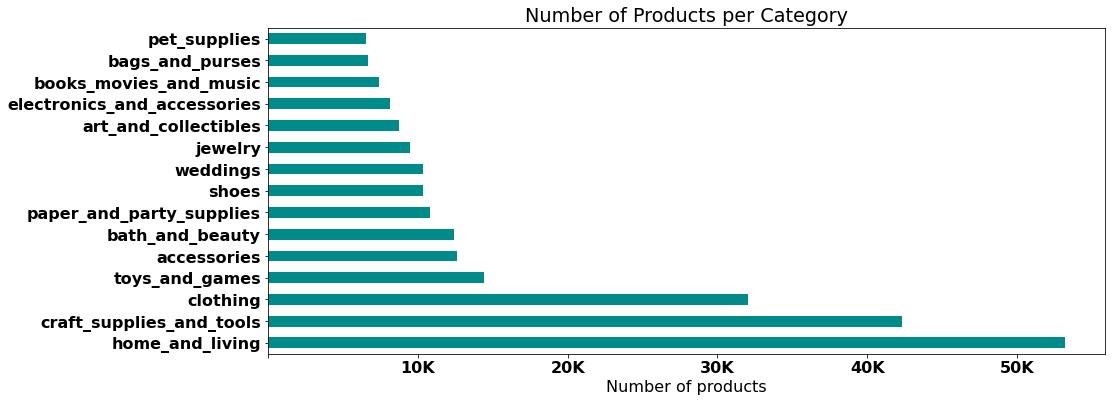

In [101]:
figsize = (15, 6)
column = 'top_category_text'
x_limit = 60000
x_step = 10000
color = 'darkcyan'
    
figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_train[column], 
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [102]:
f"Number of bottom categories in train: {len(df_train['bottom_category_text'].unique()):,}"

'Number of bottom categories in train: 2,782'

#### TFRecords

In [103]:
tfrecord_filename_train = f"{PATH}/tfrecords/train/{tfrecord_filenames_train[1]}"
raw_dataset_train = tf.data.TFRecordDataset(tfrecord_filename_train)

In [104]:
# Create a description of the features
feature_desc = {
    'product_id': tf.io.FixedLenFeature([], tf.int64),
    'title': tf.io.FixedLenFeature([], tf.string),
    'description': tf.io.FixedLenFeature([], tf.string),
    'tags': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    # only in training
    'top_category_text': tf.io.FixedLenFeature([], tf.string),
    'color_text': tf.io.FixedLenFeature([], tf.string),
    # more can be added ...
}

In [105]:
def _parse_function(example_proto):
    # Parse the input `tf.train.Example` proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, feature_desc)

In [106]:
parsed_dataset_train = raw_dataset_train.map(_parse_function)

In [107]:
def get_images(parsed_dataset, column, N=10):
    
    images = []
    titles = []
    for features in parsed_dataset.take(N):
        img_bytes = features['image/encoded'].numpy()
        if column in features:
            text = features[column].numpy().decode('utf-8')
        else:
            text = 'unknown'
        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)
        images.append(image)
        titles.append(text)

    return images, titles

In [108]:
images, titles = get_images(parsed_dataset_train, 'top_category_text')

NotFoundError: ignored

In [ ]:
def show(images, titles, N=100):
    
    num_cols = 5
    num_rows = N // num_cols
    plt_height = 3 * num_rows
    
    plt.figure(figsize=(12, plt_height))
    for i, (image, title) in enumerate(zip(images[:N], titles[:N])):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.title(title, fontsize = 12)
        plt.axis("off")
    plt.show()

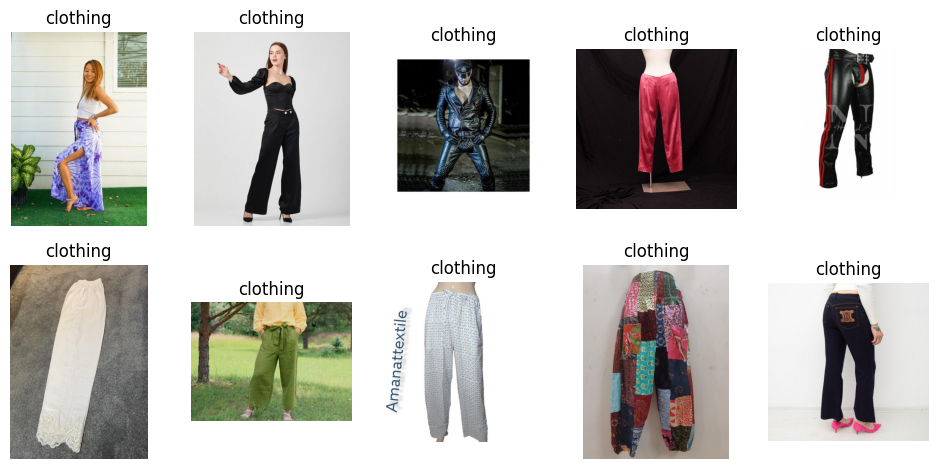

In [ ]:
show(images, titles)

### Test Dataset

The test dataset will be used to predict using the model/s you have trained

**Note** that categories and colors for the test data are hidden, you have to predict them!

#### Parquet

In [ ]:
df_test = get_parquet_data("test", len(parquet_filenames_test))

In [ ]:
f'Number of rows in test: {len(df_test):,}'

'Number of rows in test: 27,119'

In [ ]:
f"Number of unique products in test: {len(df_test['product_id'].unique()):,}"

'Number of unique products in test: 27,119'

In [ ]:
f"Number of columns in test: {len(df_test.columns):,}"

'Number of columns in test: 15'

In [ ]:
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern']

In [ ]:
df_test.iloc[0]

product_id                                            1323824090
title          12 Small Pressed Reddish-Orange Japanese Maple...
description    12 small pressed reddish-orange Japanese maple...
tags           Leaves,Art,Crafts,Paper crafts,Fall,Soap,Bookm...
type                                                    physical
room                                                        None
craft_type                                      floral arranging
recipient                                                   None
material                                                    None
occasion                                                    None
holiday                                                     None
art_subject                                                 None
style                                                       None
shape                                                       None
pattern                                                     None
Name: 0, dtype: object

#### TFRecords

In [ ]:
filename = f"{PATH}/tfrecords/test/{tfrecord_filenames_test[2]}"
raw_dataset_test = tf.data.TFRecordDataset(filename)

In [ ]:
feature_desc.pop('top_category_text')
feature_desc.pop('color_text')

FixedLenFeature(shape=[], dtype=tf.string, default_value=None)

In [ ]:
parsed_dataset_test = raw_dataset_test.map(_parse_function)

In [ ]:
images, titles = get_images(parsed_dataset_test, 'top_category_text')

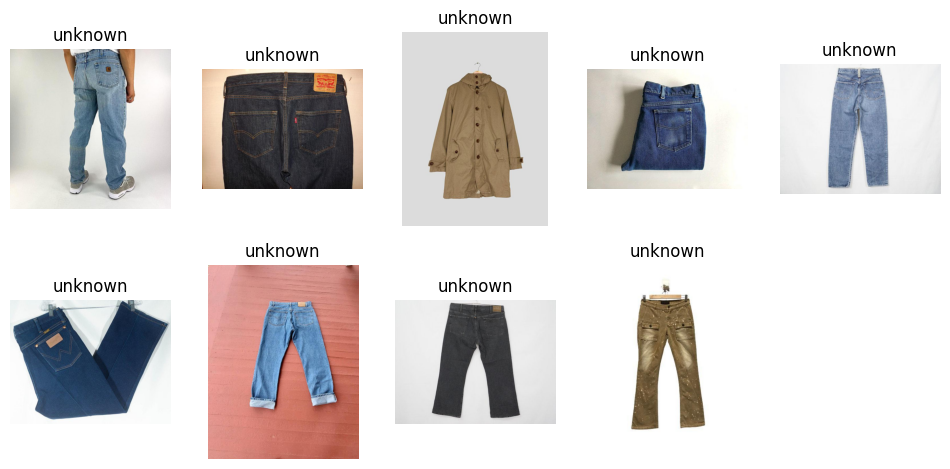

In [ ]:
show(images, titles)

## Model Training

Let's first split the data to be able to evaluate our model against a validation dataset. This validation set can also be used to fine tune your model before making the predictions on the hidden test set.

In [ ]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train, 
    test_size=0.1, 
    stratify=df_train['bottom_category_text'], 
    random_state=42)

In [ ]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 220,936'

In [ ]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 24,549'

In [ ]:
df_training['bottom_category_text'].value_counts()

electronics_and_accessories.car_parts_and_accessories.car_accessories.license_plates                                88
clothing.womens_clothing.lingerie                                                                                   88
clothing.gender_neutral_kids_clothing.hoodies_and_sweatshirts.sweatshirts                                           88
accessories.hair_accessories.headbands.baby_headbands                                                               87
pet_supplies.pet_furniture.play_furniture                                                                           87
                                                                                                                    ..
craft_supplies_and_tools.fabric_and_notions.notions.pins_and_needles.pin_and_needle_accessories.point_protectors    40
shoes.mens_shoes.sneakers_and_athletic_shoes.platform_and_club_sneakers                                             39
craft_supplies_and_tools.glue_and_adhesives.adhe

In [ ]:
df_validation['bottom_category_text'].value_counts()

toys_and_games.toys.dolls_and_action_figures.doll_clothing.shirts          10
paper_and_party_supplies.paper.stationery.programs                         10
art_and_collectibles.prints.lithographs                                    10
clothing.gender_neutral_kids_clothing.socks_and_leg_warmers.leg_warmers    10
art_and_collectibles.painting.acrylic                                      10
                                                                           ..
toys_and_games.sports_and_outdoor_games.team_sports.gymnastics              4
shoes.unisex_kids_shoes.clogs_and_mules                                     4
shoes.mens_shoes.sneakers_and_athletic_shoes.platform_and_club_sneakers     4
shoes.unisex_adult_shoes.boots.chukka_boots                                 4
books_movies_and_music.music.picks_and_slides.slides                        4
Name: bottom_category_text, Length: 2782, dtype: int64

In [ ]:
df_training['top_category_text'].value_counts()

home_and_living                47879
craft_supplies_and_tools       38110
clothing                       28827
toys_and_games                 12993
accessories                    11345
bath_and_beauty                11185
paper_and_party_supplies        9727
shoes                           9319
weddings                        9301
jewelry                         8508
art_and_collectibles            7869
electronics_and_accessories     7361
books_movies_and_music          6639
bags_and_purses                 5980
pet_supplies                    5893
Name: top_category_text, dtype: int64

In [ ]:
df_validation['top_category_text'].value_counts()

home_and_living                5321
craft_supplies_and_tools       4238
clothing                       3201
toys_and_games                 1434
accessories                    1265
bath_and_beauty                1241
paper_and_party_supplies       1084
shoes                          1036
weddings                       1032
jewelry                         949
art_and_collectibles            872
electronics_and_accessories     816
books_movies_and_music          739
bags_and_purses                 665
pet_supplies                    656
Name: top_category_text, dtype: int64

### Training

As a simple example, let's follow the [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) tutorial from scikit-learn that:

- processes the text using `CountVectorizer`, that builds a dictionary of features and transforms documents to feature vectors
- extracts term frequencies and inverse document frequencies using `TfidfTransformer`, (see [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
- trains a naïve Bayes classifier, which gives us a nice baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [ ]:
train_text = df_training['title'].fillna('').values

In [ ]:
train_labels = df_training['top_category_text'].values

In [ ]:
text_clf.fit(train_text, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation

Using our validation dataset, compute a number of metrics to measure how well we generalize on our validation set.

In [ ]:
val_text = df_validation['title'].fillna('').values
val_labels = df_validation['top_category_text'].values

In [ ]:
predictions = text_clf.predict(val_text)

In [ ]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [ ]:
f"F1 score: {f1:.4f}"

'F1 score: 0.6446'

In [ ]:
print(metrics.classification_report(val_labels, predictions))

                             precision    recall  f1-score   support

                accessories       0.83      0.39      0.53      1265
       art_and_collectibles       0.92      0.09      0.16       872
            bags_and_purses       0.91      0.29      0.44       665
            bath_and_beauty       0.91      0.51      0.65      1241
     books_movies_and_music       0.96      0.40      0.56       739
                   clothing       0.73      0.97      0.83      3201
   craft_supplies_and_tools       0.59      0.84      0.70      4238
electronics_and_accessories       0.97      0.48      0.64       816
            home_and_living       0.56      0.94      0.70      5321
                    jewelry       0.88      0.47      0.61       949
   paper_and_party_supplies       0.85      0.47      0.60      1084
               pet_supplies       0.96      0.26      0.41       656
                      shoes       0.94      0.72      0.81      1036
             toys_and_games      

In [ ]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 494,    0,    1,    7,    0,  298,  237,    0,  174,    3,    0,
           0,    1,    4,   46],
       [   2,   79,    0,    1,    3,   50,  209,    0,  508,    0,    3,
           2,    0,   15,    0],
       [   1,    0,  192,    6,    1,   36,  163,    0,  247,    3,    1,
           0,    0,   13,    2],
       [  10,    0,    5,  627,    0,   77,  206,    1,  308,    2,    0,
           0,    0,    4,    1],
       [   0,    0,    0,    2,  293,   14,  138,    5,  270,    0,    8,
           0,    0,    8,    1],
       [   7,    0,    0,    3,    0, 3090,   30,    0,   64,    0,    0,
           0,    4,    1,    2],
       [   8,    5,    1,    7,    0,   32, 3550,    2,  598,    3,   13,
           0,   10,    9,    0],
       [   2,    0,    4,    0,    3,   11,  148,  392,  247,    0,    6,
           1,    0,    2,    0],
       [   1,    1,    2,   10,    2,   51,  242,    2, 4980,    6,   10,
           1,    1,    8,    4],
       [   9,    0,    0,    2,    0,

**Note** that this is just a baseline that uses a naïve Bayes classifier and uses the `title` only as inputs, there are many more parameters that can be used in addition to multiple architectures and processing approaches

### Training

As another example, let's train an image classification model to predict color based only on the image as input. We leveraged `InceptionV3` as the base model with `imagenet` weights and freezing the layers. As we are using the TFRecord dataset, we split the filenames into train and validation. 

You might want to find a more stratified way to split between train and validation.

In [ ]:
tf_training_filenames, tf_validation_filenames = train_test_split(
    tf.io.gfile.glob(f"{PATH}/tfrecords/train/part-*.tfrecord"),
    test_size=0.2,
    random_state=42,
)

In [ ]:
f"Number of TFRecords for training: {len(tf_training_filenames):,}"

'Number of TFRecords for training: 222'

In [ ]:
f"Number of TFRecords for training: {len(tf_validation_filenames):,}"

'Number of TFRecords for training: 56'

In [ ]:
# Create a description of the features.
feature_spec = {
    'product_id': tf.io.FixedLenFeature([], tf.int64),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'color_id': tf.io.FixedLenFeature([], tf.int64),
}

def parse_dataset(example_proto, feature_spec, num_channels):
    
    features = tf.io.parse_single_example(example_proto, feature_spec)
    image_encoded = features["image/encoded"]
    img_width = features["image/width"]
    img_height = features["image/height"]
    color_id = features["color_id"]

    image = tf.reshape(
        tf.io.decode_jpeg(image_encoded),
        [img_height, img_width, num_channels],
    )
    image = tf.cast(image, tf.float32)
    label = tf.cast(tf.one_hot(color_id, NUM_COLORS), tf.int64)

    return (
        { "image": image, },
        label
    )

In [ ]:
def create_preprocessing_model(target_image_size, should_rescale):
    preprocessing_layers = []
    if should_rescale:
        preprocessing_layers.append(
            tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
        )
    preprocessing_layers.append(
        tf.keras.layers.experimental.preprocessing.Resizing(
            target_image_size, target_image_size
        )
    )
    return tf.keras.Sequential(preprocessing_layers)

In [ ]:
def transform_image_data(example, preprocessing_model):
    image = tf.expand_dims(example["image"], 0)
    example["image"] = preprocessing_model(image)[0]
    return example

In [ ]:
def get_dataset_batch(
    file_pattern: [],
    batch_size: int,
    num_channels: int,
    mode: tf.estimator.ModeKeys,
) -> tf.data.Dataset:
    
    augment = shuffle = mode == tf.estimator.ModeKeys.TRAIN

    dataset = tf.data.Dataset.list_files(
        file_pattern, shuffle=shuffle, seed=42
    )
    dataset = dataset.interleave(
        tf.data.TFRecordDataset, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    dataset = dataset.map(
        lambda x: parse_dataset(x, feature_spec, num_channels),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    preprocessing_model = create_preprocessing_model(
        target_image_size=224,
        should_rescale=True,
    )
    dataset = dataset.map(
        lambda x, y: (transform_image_data(x, preprocessing_model), y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
BATCH_SIZE = 128

In [ ]:
train_dataset = get_dataset_batch(
    file_pattern=tf_training_filenames,
    batch_size=BATCH_SIZE,
    num_channels=3,
    mode=tf.estimator.ModeKeys.TRAIN,
)

In [ ]:
val_dataset = get_dataset_batch(
    file_pattern=tf_validation_filenames,
    batch_size=BATCH_SIZE,
    num_channels=3,
    mode=tf.estimator.ModeKeys.EVAL,
)

In [ ]:
gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [ ]:
with strategy.scope():
    
    input_shape = (224, 224, 3)
    inputs = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name="image")
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_COLORS, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# model.summary()

In [ ]:
epochs = 3

hist = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1)

Epoch 1/3
INFO:tensorflow:batch_all_reduce: 192 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 192 all-reduces with algorithm = nccl, num_packs = 1
1519/1519 [==============================] - 831s 527ms/step - loss: 2.1454 - accuracy: 0.3650 - val_loss: 6.6118 - val_accuracy: 0.3339
Epoch 2/3
1519/1519 [==============================] - 793s 522ms/step - loss: 1.9508 - accuracy: 0.4193 - val_loss: 1.8446 - val_accuracy: 0.4484
Epoch 3/3
1519/1519 [==============================] - 792s 521ms/step - loss: 1.8720 - accuracy: 0.4410 - val_loss: 1.8921 - val_accuracy: 0.4406


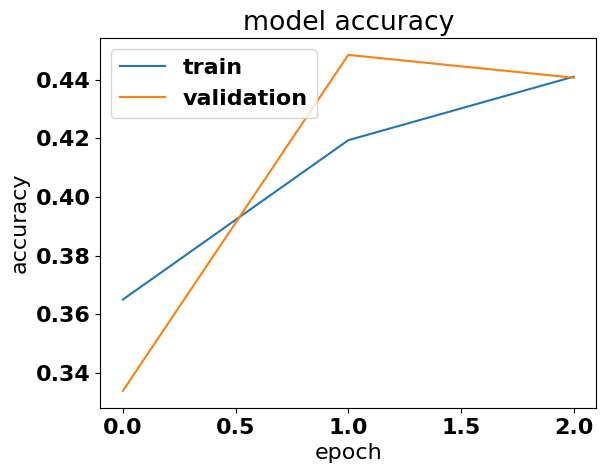

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [ ]:
model.evaluate(val_dataset, batch_size=BATCH_SIZE, verbose=1)

398/398 [==============================] - 52s 131ms/step - loss: 1.8921 - accuracy: 0.4406


[1.892129898071289, 0.44064071774482727]

In [ ]:
predictions = model.predict(val_dataset, batch_size=BATCH_SIZE, verbose=1)

398/398 [==============================] - 55s 127ms/step


**Note** again that is just another baseline that only uses the `image` as the input and generates predictions after freezing all the layers for that base model.

Go wild and try different architectures and approaches, use several modalities, apply augmentations on the preprocessing layers, predict several targets at the same time, etc!

## Submission

Prepare a submission for the test data. Here I am using some dummy values, all zeros, as the ids for top categories, bottom categories and colors. Feed-forward the test data through your model, get the predictions per product and output them onto a file to be checked against the true values.

Happy Hacking!

In [ ]:
df_predictions = df_test.copy()

In [ ]:
# dummy values
df_predictions["top_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["bottom_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["color_id"] = np.zeros(len(df_test), dtype=int)

In [ ]:
student_id = "12345689"
df_predictions[
    ["product_id", "top_category_id", "bottom_category_id", "color_id"]
].to_parquet(f"predictions_{student_id}.parquet")